In [1]:
import os
import pandas as pd
import numpy as np
#import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
rcParams['figure.figsize'] = 10, 8
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import mean_squared_error
sns.set(font='IPAGothic')
import matplotlib.pyplot as plt

In [2]:
os.getcwd()
os.chdir("C:/Users/Emmanuel Mendy/Desktop/Cours DU Python/TP économétrie/TP_4")


In [3]:
base = pd.read_csv("Base_AT.csv", delimiter=";")
base.head(10)

Mois  nb_AT
0  2006-01   1680
1  2006-02   1770
2  2006-03   1980
3  2006-04   1935
4  2006-05   1815
5  2006-06   2025
6  2006-07   2220
7  2006-08   2220
8  2006-09   2040
9  2006-10   1785

In [4]:
base.index

RangeIndex(start=0, stop=144, step=1)

In [5]:
ts = base['nb_AT']

In [6]:
df = base.copy()

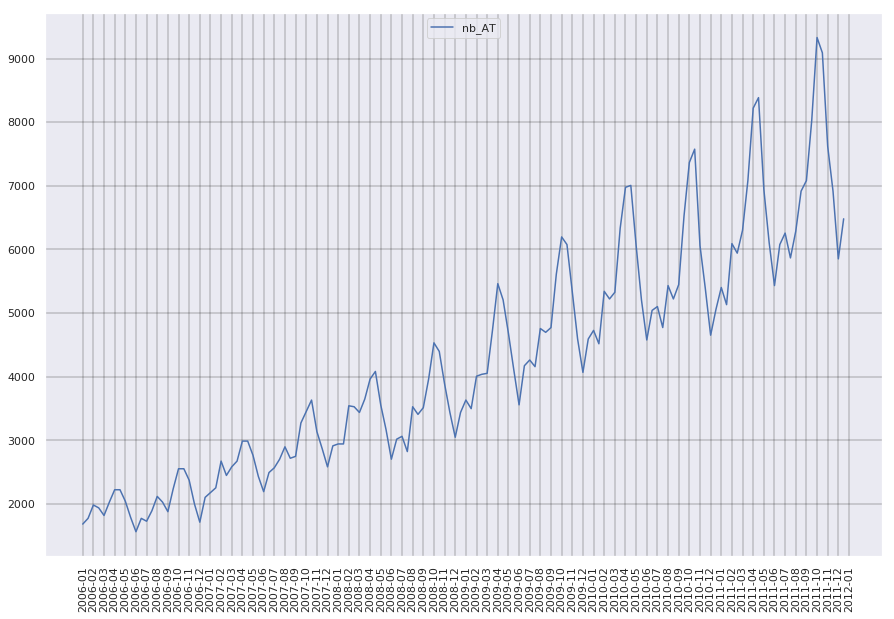

In [7]:
ds = list (df['Mois'].unique())
fig = plt.figure (figsize = (15, 10))
graph = fig.add_subplot (111)
graph.grid(linestyle='-', linewidth='0.3', color='black')

graph.plot (ds, df.nb_AT, label = 'nb_AT')
graph.set_xticklabels (ds, rotation = 'vertical')
graph.set_xticks (range (0, len(df) + 1, 2))
graph.legend (loc  = 'upper center')

In [8]:
# Analysons les MM annuelles et les EC associés
MMmoy = ts.rolling(12).mean()
MMec = ts.rolling(12).std()

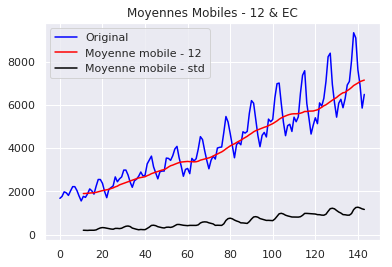

In [9]:
### Analyse graphique
plt.plot(ts, color='blue',label='Original')
plt.plot(MMmoy, color='red', label='Moyenne mobile - 12')
plt.plot(MMec, color='black', label = 'Moyenne mobile - std')
plt.legend(loc='best')
plt.title('Moyennes Mobiles - 12 & EC')
plt.show(block=False)

In [10]:
# Test de stationnarité : Dickey-Fuller
dftest = adfuller(ts, autolag='AIC')
dftest

(0.8153688792061976,
 0.9918802434376434,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 1695.369882723389)

In [11]:
# Amélioration de la lisibilité des résultats du test
dfoutput = pd.Series(dftest[0:4], index=['Stat de test','p-value','#Lags Used','Nb obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Stat de test              0.815369
p-value                   0.991880
#Lags Used               13.000000
Nb obs                  130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64

In [12]:
# pvalue = 0,99 --> Rappel: H0 : La ST est non stationnaire ==> La série n'est pas stationnaire
# # Le premier objectif est de rendre stationnaire cette series afin de calibrer un modèle
# # La non -stationnarité de la série découle de la tendance à la hausse (moyenne qui augmente) et de la saisonnalité
# On va chercher à isoler/estimer la tendance et la saisonnalité
# On aura besoin de de réutiliser cette analyse graphique et ce test : on créer une fonction
def test_stationnarite(ts):
    ### Analyse graphique
    MMmoy = ts.rolling(12).mean()
    MMec = ts.rolling(12).std()
    plt.plot(ts, color='blue',label='Original')
    plt.plot(MMmoy, color='red', label='Moyenne mobile - 12')
    plt.plot(MMec, color='black', label = 'Moyenne mobile - std')
    plt.legend(loc='best')
    plt.title('Moyennes Mobiles - 12 & EC')
    plt.show(block=False) 

In [13]:
# Test de stationnarité : Dickey-Fuller
dftest = adfuller(ts, autolag='AIC')
dftest

(0.8153688792061976,
 0.9918802434376434,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 1695.369882723389)

In [14]:
# Amélioration de la lisibilité des résultats du test
dfoutput = pd.Series(dftest[0:4], index=['Stat de test','p-value','#Lags Used','Nb obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput);

Stat de test              0.815369
p-value                   0.991880
#Lags Used               13.000000
Nb obs                  130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


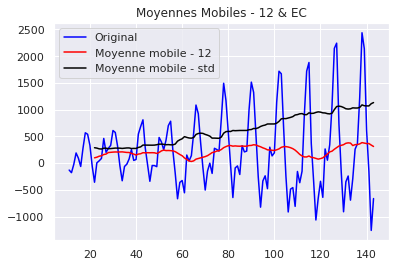

In [15]:
###################################################################################################################
###                                   MODELISATION                                                            ####
###################################################################################################################


### Estimation et elimination de la tendance
# On reraite de la MM
ts_ssMM12 = ts - MMmoy
ts_ssMM12.dropna(inplace=True)
test_stationnarite(ts_ssMM12)


0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11   -0.065494
Name: nb_AT, dtype: float64

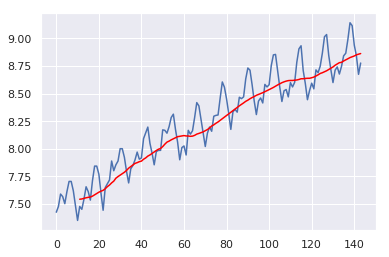

In [16]:
# La série semble être toujours haussière : on va chercher à pénaliser la fin de series
log_ts = np.log(ts)
MMmoy_log = log_ts.rolling(12).mean()
plt.plot(log_ts)
plt.plot(MMmoy_log, color='red')
log_ts_diff = log_ts - MMmoy_log
log_ts_diff.head(12)

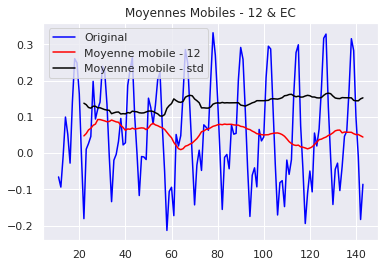

In [17]:
# Comme on s'y attend les 11 premières valeurs sont inexistantes : on les supprimes
log_ts_diff.dropna(inplace=True)
test_stationnarite(log_ts_diff)
# Le test confirme l'analyse graphique : on peut affirmer à 95% que la série est stationnaire


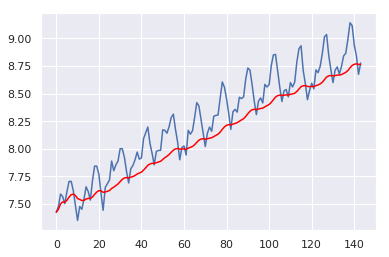

In [18]:
# Utilisons une autre méthode plus dynamique : en effet, ici la fenetre temporelle de 12 mois est statique
# On va utiliser la méthode de la MM pondérée afin d'accorder plus de poids aux valeurs récentes
MMPond = log_ts.ewm(halflife=12).mean()         # halflife : décroisance exponentielle
plt.plot(log_ts)
plt.plot(MMPond, color='red')
# Les premièrs mois ont une valeur...

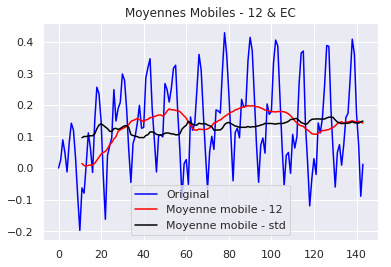

In [19]:
# Retraitons la série de cette MM
log_ts_ewm_diff = log_ts - MMPond
test_stationnarite(log_ts_ewm_diff)    
# Cette ST a moins de moyenne et d'EC ; cela est confirmé par le test : nettement plus satisfaisant
# Il smeble y avoir encore une aléa pas si aléatoire, un cycle annuel....


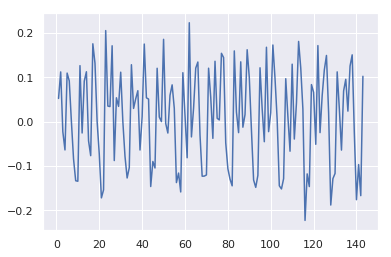

In [20]:
#### Elimination dela tendance et de la saisonnalité
# Methode de differenciation : on retranche à la série un décalage temporel
log_ts_shift = log_ts - log_ts.shift()          # Diff obs(t) - obs(t-1) : 1 par défaut
plt.plot(log_ts_shift)

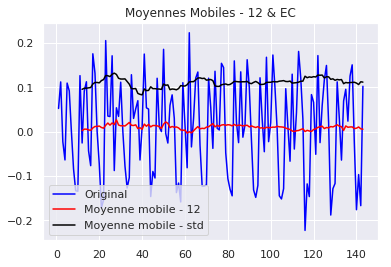

In [21]:
# La saisonnalité semble être atténuée

log_ts_shift.dropna(inplace=True)
test_stationnarite(log_ts_shift)

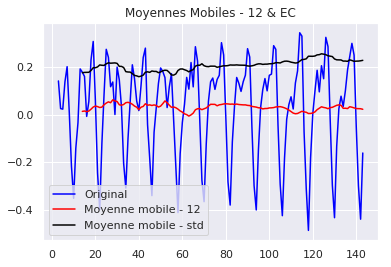

In [22]:
# Pas top... on augmente le décalage temporel

log_ts_shift = log_ts - log_ts.shift(periods=3)        
log_ts_shift.dropna(inplace=True)
test_stationnarite(log_ts_shift)
# Pas trop mieux, on garde le 1

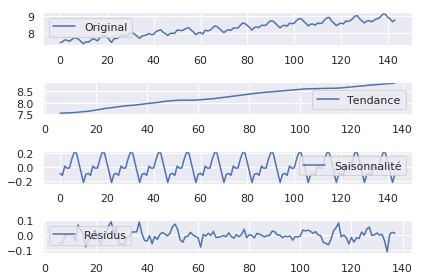

In [37]:
# Methode de décomposition : On estime la tendance et la saisonnalité séparemment
#decompfreq = 24*60/15*7
decomp = sm.tsa.seasonal_decompose(log_ts, model='additive', freq = 12)
tend = decomp.trend
saison = decomp.seasonal
bruit = decomp.resid

plt.subplot(411)
plt.plot(log_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tend, label='Tendance')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(saison,label='Saisonnalité')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(bruit, label='Résidus')
plt.legend(loc='best')
plt.tight_layout()

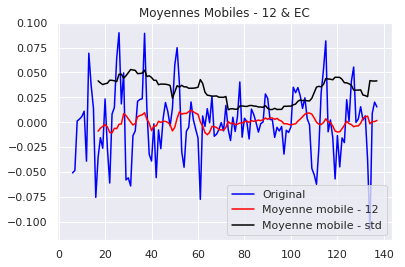

In [38]:
# La tendance et la saisonnalité sont identifiées et isolée
# Les réidus sont-ils stationnaires ?
bruit.dropna(inplace=True)
test_stationnarite(bruit)
# Le test rejete fortement l'hypothèse alternative : le bruit est stationnaire

In [39]:
# Maintenant que la tendance et la saisonnalité sont isolées et estimées il reste à modéliser les résidus :
# Si ils sont strictement stationnaires et indépendants on peu tles modéliser en tant que Bruit blanc
# Si ils sont dépendants alors utilisation des modèles dédiées tq ARIMA  

# ARIMA: Auto-Regressive Integrated Moving Averages : équation linéaire dépendant des paramètres suivants :
# p : le nombre de retards (Auto-regressive) : nombre d'observations correlées / prédicteurs
# q : le nombre de termes de la MM (Moving Averages) : fenetre de la MM
# d : nombre de différence non saisonnières, nombre de décalage (shift): nous avons utiliser un décalage de 1 
# Objectif: déterminer p et q : Utilisation des méthodes graphiques ACF et PACF
log_ts_shift = log_ts - log_ts.shift()  
log_ts_shift.dropna(inplace=True)  
lag_acf = acf(log_ts_shift, nlags=20)
lag_pacf = pacf(log_ts_shift, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

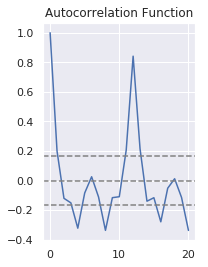

In [40]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_ts_shift)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

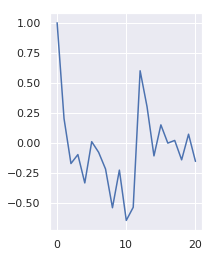

In [43]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.show()


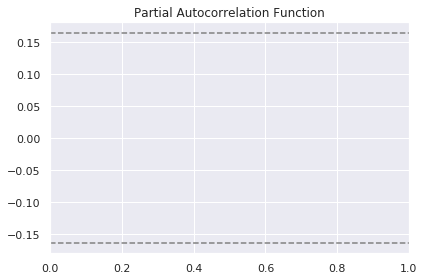

In [44]:
#hline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_ts_shift)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
# On peut utiliser les lignes de l'intervalle de confiance pour déterminer p et q :
# Premère valeur de croisement de PACF avec l'IC sup : 2
# Premère valeur de croisement de ACF avec l'IC sup : 2
